# COMP5318 Assignment 1: Rice Classification

##### Group number: Assignment1-groups 3
##### Student 1 SID: 540784343
##### Student 2 SID: 520330054  
##### Student 3 SID: 540666979 
##### Student 4 SID: 540831430

In [1]:
# Import all libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression         
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import colors

from sklearn.metrics import accuracy_score

In [2]:
import sklearn
print(sklearn.__version__)

1.2.2


In [3]:
# Ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load the rice dataset: rice-final2.csv
rice = pd.read_csv('rice-final2.csv')

# print(f'dataset shape: {rice.shape}')
# print(f'columns name: {rice.columns.tolist()}')
# print(rice.head(10))

In [5]:
# Pre-process dataset
# separate feature and target
feature = rice.columns[:-1]
target = rice.columns[-1]
# print(feature)
# print(target)


# 1.missing attribute values -> mean value
X_raw = rice[feature].apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy='mean')
X_impute = imputer.fit_transform(X_raw)
# print(X_impute[:, 0].mean())
# print(X_impute[155])
# print(X_impute[6])


# 2.MinMax normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_impute)


#3. replace class1 -> 0, class2 -> 1
y_raw = rice[target].astype(str).str.strip()
RiceClass = {'class1': 0, 'class2': 1}
y = y_raw.map(RiceClass)
# print(y.head(10))


#into numpy array
X = X_scaled.astype(float)
y = y.to_numpy().astype(int)

# 4.Print first ten rows of pre-processed dataset to 4 decimal places as per assignment spec
# A function is provided to assist

def print_data(X, y, n_rows=10):
    """Takes a numpy data array and target and prints the first ten rows.
    
    Arguments:
        X: numpy array of shape (n_examples, n_features)
        y: numpy array of shape (n_examples)
        n_rows: numpy of rows to print
    """
    for example_num in range(n_rows):
        for feature in X[example_num]:
            print("{:.4f}".format(feature), end=",")

        if example_num == len(X)-1:
            print(y[example_num],end="")
        else:
            print(y[example_num])
print_data(X, y, n_rows=10)         


0.4628,0.5406,0.5113,0.4803,0.7380,0.4699,0.1196,1
0.4900,0.5547,0.5266,0.5018,0.7319,0.4926,0.8030,1
0.6109,0.6847,0.6707,0.5409,0.8032,0.6253,0.1185,0
0.6466,0.6930,0.6677,0.5961,0.7601,0.6467,0.2669,0
0.6712,0.6233,0.4755,0.8293,0.3721,0.6803,0.4211,1
0.2634,0.2932,0.2414,0.4127,0.5521,0.2752,0.2825,1
0.8175,0.9501,0.9515,0.5925,0.9245,0.8162,0.0000,0
0.3174,0.3588,0.3601,0.3908,0.6921,0.3261,0.8510,1
0.3130,0.3050,0.2150,0.5189,0.3974,0.3159,0.4570,1
0.5120,0.5237,0.4409,0.6235,0.5460,0.5111,0.3155,1


In [6]:
#variables to handle experiment analysis visualizations
boxplot_data = []
estimators = []

### Part 1: Cross-validation without parameter tuning

In [7]:
## Setting the 10 fold stratified cross-validation
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# The stratified folds from cvKFold should be provided to the classifiers

In [8]:
# Logistic Regression
def logregClassifier(X, y):
    model = LogisticRegression(max_iter=1000, random_state=0)
    scores = cross_val_score(model, X, y, cv=cvKFold, scoring='accuracy')
    boxplot_data.append(scores)
    estimators.append(('LR', model))
    return scores.mean()

In [9]:
#Naïve Bayes
def nbClassifier(X, y):
    model = GaussianNB()
    scores = cross_val_score(model, X, y, cv=cvKFold, scoring='accuracy')
    boxplot_data.append(scores)
    estimators.append(('NB', model))
    return scores.mean()

In [10]:
# Decision Tree
def dtClassifier(X, y):
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    boxplot_data.append(scores)
    estimators.append(('DT', clf))
    return scores.mean()

In [11]:
# Ensembles: Bagging, Ada Boost and Gradient Boosting
def bagDTClassifier(X, y, n_estimators, max_samples, max_depth):
    base_dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=0)
    bag = BaggingClassifier(
        estimator=base_dt,
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=0,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True
    )
    scores = cross_val_score(bag, X, y, cv=cvKFold, scoring='accuracy', n_jobs=-1)
    boxplot_data.append(scores)
    estimators.append(('Bagging', bag))
    return scores.mean()

def adaDTClassifier(X, y, n_estimators, learning_rate, max_depth):  
    base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=0)
    clf = AdaBoostClassifier(estimator = base_estimator, n_estimators=n_estimators, learning_rate = learning_rate, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold, scoring='accuracy', n_jobs=-1)
    boxplot_data.append(scores)
    estimators.append(('AdaBoost', clf))
    return scores.mean()

def gbClassifier(X, y, n_estimators, learning_rate):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    boxplot_data.append(scores)
    estimators.append(('GB', clf))
    return scores.mean()

In [12]:
# Parameters for Part 1:

#Bagging
bag_n_estimators = 50
bag_max_samples = 100
bag_max_depth = 5

#AdaBoost
ada_n_estimators = 50
ada_learning_rate = 0.5
ada_bag_max_depth = 5

#GB
gb_n_estimators = 50
gb_learning_rate = 0.5

# Print results for each classifier in part 1 to 4 decimal places here:
print(f"LogR average cross-validation accuracy:{logregClassifier(X, y):.4f}")
print(f"NB average cross-validation accuracy:{nbClassifier(X, y):.4f}")
print(f"DT average cross-validation accuracy: {dtClassifier(X,y):.4f}")
print(f"Bagging average cross-validation accuracy: {bagDTClassifier(X, y, bag_n_estimators, bag_max_samples, bag_max_depth):.4f}")
print(f"AdaBoost average cross-validation accuracy: {adaDTClassifier(X, y, ada_n_estimators, ada_learning_rate, ada_bag_max_depth):.4f}")
print(f"GB average cross-validation accuracy: {gbClassifier(X, y, gb_n_estimators, gb_learning_rate):.4f}")

LogR average cross-validation accuracy:0.9386
NB average cross-validation accuracy:0.9264
DT average cross-validation accuracy: 0.9179
Bagging average cross-validation accuracy: 0.9414
AdaBoost average cross-validation accuracy: 0.9250
GB average cross-validation accuracy: 0.9300


### Part 2: Cross-validation with parameter tuning

In [13]:
# KNN
k = [1, 3, 5, 7]
p = [1, 2]


def bestKNNClassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    knn = KNeighborsClassifier()

    param_grid = {
        "n_neighbors": k,
        "p": p,
    }

    grid = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cvKFold,
        n_jobs=-1,
        refit=True,
        return_train_score=False
    )

    grid.fit(X_train, y_train)
    
    best_k = int(grid.best_params_["n_neighbors"])
    best_p = int(grid.best_params_["p"])
    best_cv_acc = float(grid.best_score_)
    
    estimators.append((f"KNN(k={best_k}, p={best_p})", grid))
    mask = (grid.cv_results_["param_n_neighbors"] == best_k) & \
           (grid.cv_results_["param_p"] == best_p)
    fold_scores = grid.cv_results_["split0_test_score"][mask][0:1]
    fold_scores = []
    n_splits = cvKFold.get_n_splits()
    for i in range(n_splits):
        key = f"split{i}_test_score"
        fold_scores.extend(grid.cv_results_[key][mask])
    
    boxplot_data.append(fold_scores)
    y_pred = grid.best_estimator_.predict(X_test)
    test_acc = float(accuracy_score(y_test, y_pred))

    return best_k, best_p, best_cv_acc, test_acc

In [14]:
# Random Forest
# You should use RandomForestClassifier from sklearn.ensemble with information gain and max_features set to ‘sqrt’.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

n_estimators = [10, 30, 60, 100]
max_leaf_nodes = [6, 12]

def bestRFClassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
    param_grid = {'n_estimators':n_estimators, 'max_leaf_nodes': max_leaf_nodes}
    clf = GridSearchCV(RandomForestClassifier(max_features='sqrt', criterion='entropy', random_state=0), 
                       param_grid=param_grid, 
                       cv=cvKFold, 
                       return_train_score=True)
    
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    report = classification_report(y_test, y_predicted, output_dict=True)
    
    mask = (clf.cv_results_["param_n_estimators"] == clf.best_params_["n_estimators"]) & \
           (clf.cv_results_["param_max_leaf_nodes"] == clf.best_params_["max_leaf_nodes"])
    fold_scores = []
    n_splits = cvKFold.get_n_splits()
    for i in range(n_splits):
        key = f"split{i}_test_score"
        fold_scores.extend(clf.cv_results_[key][mask])
        
    boxplot_data.append(fold_scores)
    estimators.append((f"RF(n={clf.best_params_['n_estimators']}, L={clf.best_params_['max_leaf_nodes']})", clf))
    
    results = {
        "best_n_estimators": clf.best_params_["n_estimators"],
        "best_max_leaf_nodes": clf.best_params_["max_leaf_nodes"],
        "cross_validation_accuracy": clf.best_score_,
        "test_set_accuracy": report["accuracy"],
        "test_set_macro_average_f1": report["macro avg"]["f1-score"],
        "test_set_weighted_average_f1": report["weighted avg"]["f1-score"],
    }
    return results

In [15]:
# Perform Grid Search with 10-fold stratified cross-validation (GridSearchCV in sklearn). 
# The stratified folds from cvKFold should be provided to GridSearchV

# This should include using train_test_split from sklearn.model_selection with stratification and random_state=0
# Print results for each classifier here. All results should be printed to 4 decimal places except for
# "k", "p", n_estimators" and "max_leaf_nodes" which should be printed as integers.
best_k, best_p, best_cv_acc, test_acc = bestKNNClassifier(X, y)
RFClassifier = bestRFClassifier(X, y)

print("KNN best k: {}".format(best_k))
print("KNN best p: {}".format(best_p))
print("KNN cross-validation accuracy: {:.4f}".format(best_cv_acc))
print("KNN test set accuracy: {:.4f}".format(test_acc))

print()

print(f"RF best n_estimators: {RFClassifier['best_n_estimators']}")
print(f"RF best max_leaf_nodes: {RFClassifier['best_max_leaf_nodes']}")
print(f"RF cross-validation accuracy: {RFClassifier['cross_validation_accuracy']:.4f}")
print(f"RF test set accuracy: {RFClassifier['test_set_accuracy']:.4f}")
print(f"RF test set macro average F1: {RFClassifier['test_set_macro_average_f1']:.4f}")
print(f"RF test set weighted average F1: {RFClassifier['test_set_weighted_average_f1']:.4f}")

KNN best k: 5
KNN best p: 1
KNN cross-validation accuracy: 0.9371
KNN test set accuracy: 0.9257

RF best n_estimators: 30
RF best max_leaf_nodes: 12
RF cross-validation accuracy: 0.9390
RF test set accuracy: 0.9371
RF test set macro average F1: 0.9355
RF test set weighted average F1: 0.9370


# Graphs

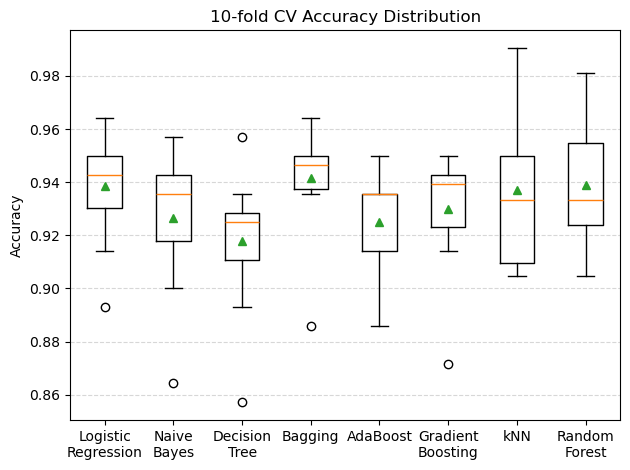

In [16]:
import matplotlib.pyplot as plt
plt.boxplot(
    boxplot_data,
    labels=["Logistic\nRegression", "Naive\nBayes", "Decision\nTree", "Bagging", "AdaBoost", "Gradient\nBoosting", "kNN", "Random\nForest"],
    showmeans=True,
)
plt.ylabel("Accuracy")
plt.title("10-fold CV Accuracy Distribution")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#compute normalized confusion matrix and CV accuracy
def oof_confusion_and_acc(model, X, y, cv):
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    acc = (y == y_pred).mean()
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    return cm_norm, acc


sns.set_theme(style="white")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for ax, (name, model) in zip(axes, estimators):
    cm_norm, acc = oof_confusion_and_acc(model, X, y, cvKFold)
    

    heatmap = sns.heatmap(
        cm_norm, annot=False, fmt=".2f", cmap="viridis",
        cbar=False, square=True, ax=ax,
        xticklabels=[0, 1], yticklabels=[0, 1]
    )
    

    collections = heatmap.collections[0]

    facecolors = collections.get_facecolors()

    if facecolors.ndim == 1:
        facecolors = np.array([facecolors])
    

    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            idx = i * cm_norm.shape[1] + j
            
            if idx < len(facecolors):
                color = facecolors[idx]
                
                if len(color) >= 3:
                    brightness = np.dot(color[:3], [0.299, 0.587, 0.114])

                    text_color = 'black' if brightness > 0.6 else 'white'
                    
                    ax.text(j + 0.5, i + 0.5, f'{cm_norm[i, j]:.2f}',
                           ha='center', va='center',
                           color=text_color, fontsize=11, fontweight='bold')
    
    ax.set_title(f"{name} CV Confusion Matrix (CV acc={acc:.4f})", fontsize=12)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()
fig.savefig("ConfusionMatrix.png", dpi=300, bbox_inches="tight")
